In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk # sudo pip3 install lightkurve

import kepler_io
## These are the import statments in kepler_io
# import os.path
# from os import path
# from astropy.io import fits
# import numpy as np
## If you don't have astopy, sudo pip3 install astropy

from lightkurve import *

In [2]:
# TCE_DIR = "dr24_tce.csv"
TCE_DIR = "dr24_tce_full.csv"
tce_df = pd.read_csv(TCE_DIR, skiprows=159)

k90 = tce_df[tce_df.kepid == 11442793]
row = k90.iloc[0]
row

rowid                           17695
kepid                        11442793
tce_plnt_num                        1
tce_rogue_flag                    NaN
tce_delivname         q1_q17_dr24_tce
                           ...       
tce_dikco_mra_err              0.0749
tce_dikco_mdec               -0.13243
tce_dikco_mdec_err             0.0964
tce_dikco_msky                0.13277
tce_dikco_msky_err             0.0963
Name: 17694, Length: 156, dtype: object

In [3]:
"""
You need to store the 87.23 GB kepler directory outside of github's reach. You don't want to commit that. 

Here's a file system that would work with the existing code.
/SIR/kepler
/SIR/PlanetHuntersRepo/dr24_tce
/SIR/PlanetHuntersRepo/dataCleansing.ipynb
/SIR/PlanetHuntersRepo/kepler_io.py

"""


KEPLER_DATA_DIR = "../kepler/"

# Read the light curve.
file_names = kepler_io.kepler_filenames(KEPLER_DATA_DIR, row.kepid)
assert file_names, "Failed to find .fits files in {}".format(KEPLER_DATA_DIR)

all_time, all_flux = kepler_io.read_kepler_light_curve(file_names)
print("Read light curve with {} segments".format(len(all_time)))



Read light curve with 14 segments


In [4]:
# Feed lightcurve into lightkurve engine
filename = file_names[0]
tpf = lk.lightcurvefile.KeplerLightCurveFile(filename) # import the given filename into lightkurve
sap_lc = tpf.SAP_FLUX
pdcsap_lc = tpf.PDCSAP_FLUX

The following cell shows the difference between raw SAP_FLUX and cleansing with KeplerCBVCorrector.
The math is briefly described in the docs: https://docs.lightkurve.org/api/lightkurve.correctors.KeplerCBVCorrector.html#lightkurve.correctors.KeplerCBVCorrector

The result of using CBV is extremely similar to (yet not identical to) PDCSAP_FLUX, provided by NASA with the downloaded lightcurve files. However, NASA's method is "subject to change," meaning that their documentation could be updated to describe a different method than what was used when the data was previously downloaded. 

Additionally, CBV is something that we can control when generating simulated transits.

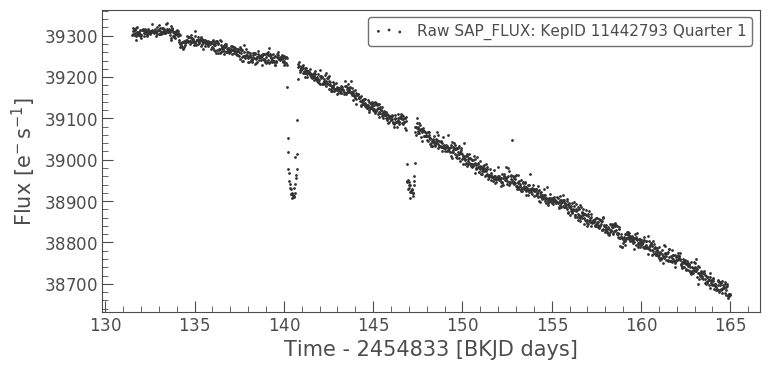

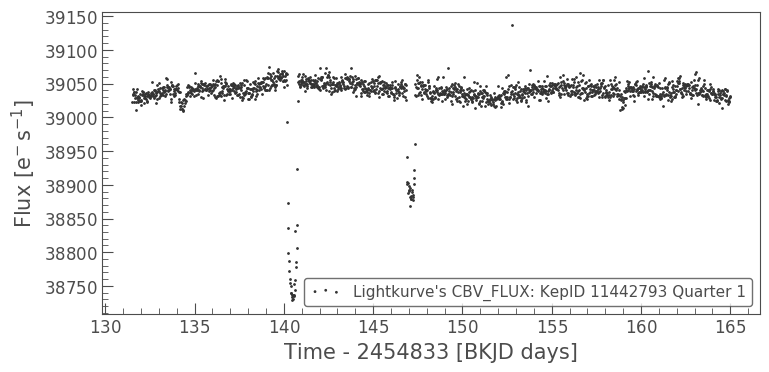

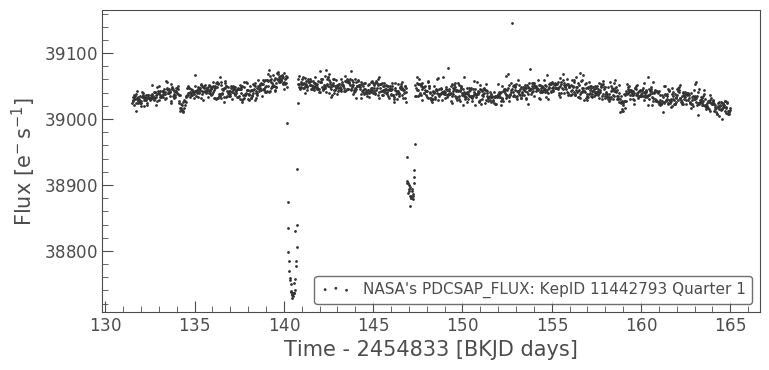

In [5]:
cbv_lc = KeplerCBVCorrector(sap_lc).correct()
sap_lc.scatter(label="Raw SAP_FLUX: KepID {} Quarter {}".format(sap_lc.targetid, sap_lc.quarter))
cbv_lc.scatter(label="Lightkurve's CBV_FLUX: KepID {} Quarter {}".format(cbv_lc.targetid, cbv_lc.quarter))
pdcsap_lc.scatter(label="NASA's PDCSAP_FLUX: KepID {} Quarter {}".format(pdcsap_lc.targetid, pdcsap_lc.quarter))

As CBV_FLUX and PDCSAP_FLUX can appear to be identical when plotted on two separate graphs, the following plot shows the two on the same graph.

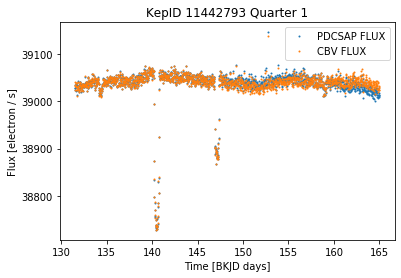

In [6]:
plt.plot(pdcsap_lc.time, pdcsap_lc.flux, 'o', markersize=1, label='PDCSAP FLUX')
plt.plot(cbv_lc.time, cbv_lc.flux, 'o', markersize=1, label='CBV FLUX')
plt.title("KepID {} Quarter {}".format(pdcsap_lc.targetid, pdcsap_lc.quarter))
plt.ylabel("Flux [{}]".format(cbv_lc.flux_unit))
plt.xlabel("Time [{} days]".format(cbv_lc.time_format.upper()))
plt.legend()

The following method flattens the cbv lightcurve using a Savitzky-Golay filter.


Docs: https://docs.lightkurve.org/api/lightkurve.lightcurve.KeplerLightCurve.html#lightkurve.lightcurve.KeplerLightCurve.flatten


Savitzky-Golay filter https://en.wikipedia.org/wiki/Savitzky–Golay_filter

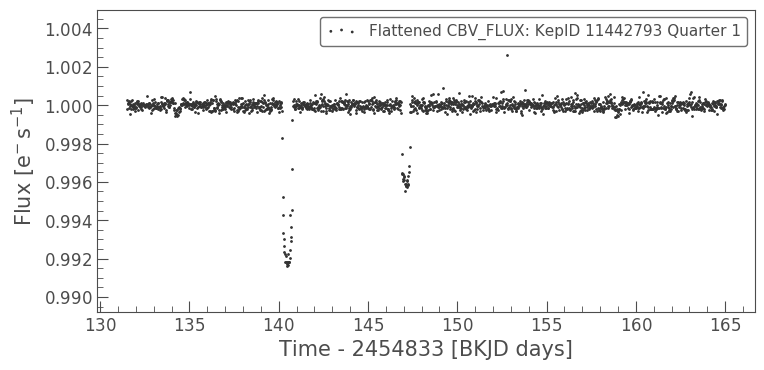

In [7]:
flat_lc = cbv_lc.flatten()
flat_lc.scatter(label="Flattened CBV_FLUX: KepID {} Quarter {}".format(flat_lc.targetid, flat_lc.quarter))

NameError: name 'kid' is not defined

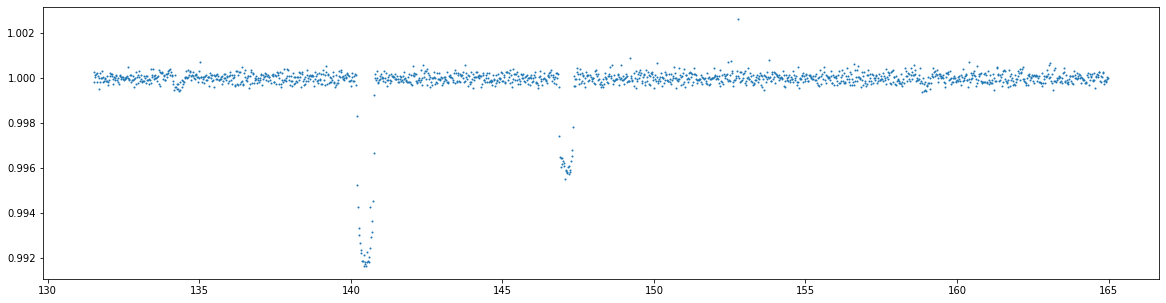

In [8]:

plt.figure(figsize=(20,5))
plt.plot(flat_lc.time, flat_lc.flux, 'o', markersize=1)
target_rows = tce_df[tce_df.kepid == kid]
for i in range(len(target_rows)):
    
    # It's okay to add hours to BKJD days, it's like a Kelvin to Celcius conversion.
    time, duration = target_rows['tce_time0bk'].iloc[i], (target_rows['tce_duration'].iloc[i]+target_rows['tce_duration_err'].iloc[i])/24.0
    
    plt.axvline(x=time+duration, c='r')
    plt.axvline(x=time-duration, c='r')
    plt.axvline(x=time, c='g')
    
    

The following removes >3σ outliers from the median using lightkurve's "remove_outliers" function. 

The current issue with this is that it erases the transit entirely. What we need to do is center the 

In [20]:
def remove_outliers_with_protected_range(lc, r):
    time, duration = r['tce_time0bk'], (r['tce_duration']+r['tce_duration_err'])/24.0
    upperBoundTime = time + duration
    lowerBoundTime = time - duration
    outlier_mask = lc.remove_outliers(sigma=3.0, return_mask=True)[1] # True for all >3σ points from the median
    newFlux = []
    for i, t in enumerate(lc.time):
        isOutlier = outlier_mask[i]
        flux = lc.flux[i]
        isProtected = (t > lowerBoundTime) and (t < upperBoundTime)
        append_flux = flux if isProtected or (not isOutlier) else np.nan
        newFlux.append(append_flux)
    lc.flux = np.array(newFlux)
    return lc

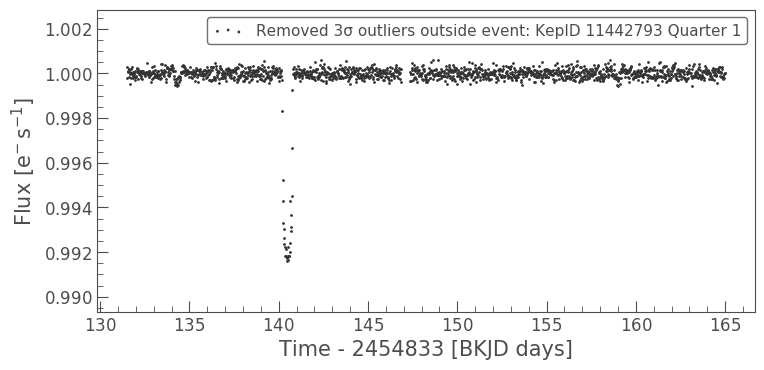

In [22]:
removed_outliers = remove_outliers_with_protected_range(flat_lc, row)
removed_outliers.scatter(label="Removed 3σ outliers outside event: KepID {} Quarter {}".format(flat_lc.targetid, flat_lc.quarter))


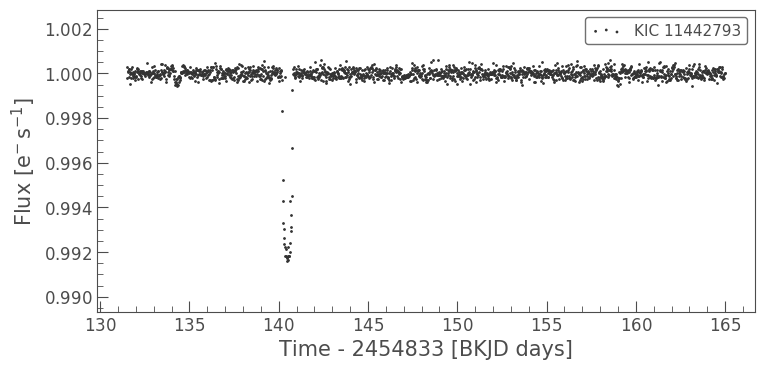

In [23]:
filled_lc = removed_outliers.fill_gaps()
filled_lc.scatter()

In [31]:
def focus_event(lc, r):
    time = r['tce_time0bk']
    lc = lc.fold(time)
    return lc

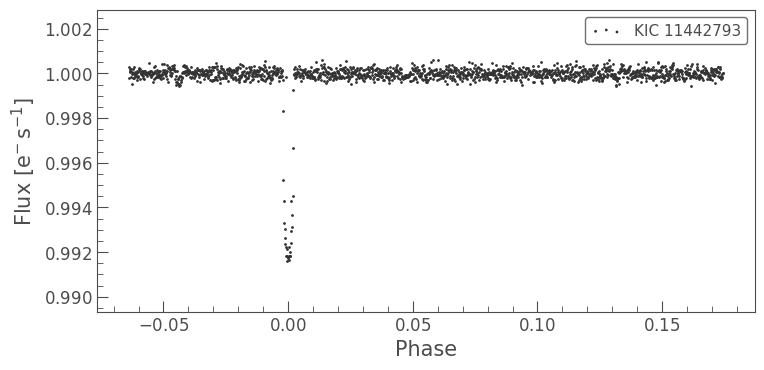

In [32]:
focus_event(filled_lc, row).scatter()